# 空洞卷积实验

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 设置中文支持
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 数据准备

In [4]:
class FoggyDataset(Dataset):
    def __init__(self, foggy_dir, defog_dir, transform=None):
        self.foggy_dir = foggy_dir
        self.defog_dir = defog_dir
        self.transform = transform
        self.foggy_images = os.listdir(foggy_dir)
        self.defog_images = os.listdir(defog_dir)

    def __len__(self):
        return len(self.foggy_images)

    def __getitem__(self, idx):
        foggy_img_name = os.path.join(self.foggy_dir, self.foggy_images[idx])
        defog_img_name = os.path.join(self.defog_dir, self.defog_images[idx])
        foggy_img = Image.open(foggy_img_name).convert('RGB')
        defog_img = Image.open(defog_img_name).convert('RGB')

        if self.transform:
            foggy_img = self.transform(foggy_img)
            defog_img = self.transform(defog_img)

        return foggy_img, defog_img


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 有雾图片文件夹路径
foggy_dir = r'Datasets\RemoveFogDatasets\FogPictures'
# 去雾图片文件夹路径
defog_dir = r'Datasets\RemoveFogDatasets\NoFogPictures'

dataset = FoggyDataset(foggy_dir, defog_dir, transform)

# 计算用于划分训练集和测试集的样本数量
total_samples = len(dataset)
train_samples = int(0.8 * total_samples)
test_samples = total_samples - train_samples

# 划分训练集和测试集
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_samples, test_samples])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练集大小：", len(train_dataset))

训练集大小： 416


## 函数准备

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 绘图函数

In [58]:
# 定义绘图函数

# 绘制训练损失和测试损失的函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label="train", color="red", linewidth=1)
    plt.plot(x, test_loss, label="test", color="blue", linewidth=1)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 绘制损失值对比函数
def loss_comparison(losses, labels, title):
    markers = ['o', 'p', '*', 'v', 'h', 'H', '+', 'x', 'D', 'd']
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(losses[0]))
    for idx, loss in enumerate(losses):
        plt.plot(x, loss, label=labels[idx], marker=markers[idx], markersize=5, linewidth=1)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 定义训练时间对比图
def train_time_comparison(times, labels, title):
    plt.figure(dpi=100)
    bars = plt.bar(labels, times, color=['blue', 'green', 'red'])

    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')

    # 在每个柱子上方显示时间数据
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(time), ha='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


### 模型训练和测试函数

In [8]:
# 训练函数
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    train_batch_num = len(data_loader)
    total_loss = 0

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data, target = data.to(device).float(), target.to(device).float()

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        output = model(data)
        # 计算损失
        loss = criterion(output, target)
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
        
        # 累加loss
        total_loss += loss.item()

    loss = total_loss / train_batch_num
    return loss

# 测试函数
def test_model(model, data_loader, criterion, device):
    model.eval()
    test_batch_num = len(data_loader)
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    loss = total_loss / test_batch_num
    return loss

# 模型训练过程函数
def train(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    # 训练模型并验证
    train_losses = []
    test_losses = []
    start = time.time()

    # 进行训练
    for epoch in range(epochs):
        # 在训练集上训练
        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)

        # 在测试集上训练
        test_loss = test_model(model, test_loader, criterion, device=device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch: {epoch + 1}/{epochs},\t train_loss: {train_loss:.4f},\t test_loss: {test_loss:.4f}')

    end = time.time()
    print(f'\n训练结毕，耗时：{end - start}s')
    return train_losses, test_losses


### 模型定性分析函数

In [10]:
# 定义模型定性分析的函数
def qualitative_Analysis(model, datasets, mdoelPath, title):
    # model：训练好的模型；datasets：抽样的数据集；modelPath：保存模型的路径；title：损失图像标题
    
    checkpoint = torch.load(mdoelPath)  # 替换为你的模型检查点文件路径
    # 绘制损失图
    plot_loss(checkpoint['other_info']['train_losses'], checkpoint['other_info']['test_losses'], title=title)

    model.load_state_dict(checkpoint['model_state'])
    model.eval()  # 设置模型为评估模式

    # 抽样显示训练集中图片
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("带雾图——模型输出图——去雾图", fontsize=10)
    for i in range(3):
        # 使用模型进行预测
        rand_num = np.random.randint(1, 101)
        with torch.no_grad():
            # 随机选取图片输入
            output = model(datasets[i+rand_num][0].unsqueeze(0)).squeeze()
        axes[i][0].imshow(transforms.ToPILImage()(datasets[i+rand_num][0]))
        axes[i][0].axis('off')
        axes[i][1].imshow(transforms.ToPILImage()(output))
        axes[i][1].axis('off')
        axes[i][2].imshow(transforms.ToPILImage()(datasets[i+rand_num][1]))
        axes[i][2].axis('off')

    plt.show()

## 1.torch.nn实现空洞卷积

In [67]:
# 空洞卷积的实现
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out
    
# 测试模型输出的shape
# model = DilatedConvModule()
# criterion = nn.MSELoss()
# for X, y in train_loader:
#     y_hat = model(X)
#     print("模型输出的shape", y_hat.shape)
#     print("去雾图片的shape", y.shape)
#     loss = criterion(y_hat, y)
#     print("loss", loss)
#     break    

模型输出的shape torch.Size([32, 3, 128, 128])
去雾图片的shape torch.Size([32, 3, 128, 128])
loss tensor(0.5058, grad_fn=<MseLossBackward0>)


In [43]:
# 初始化模型和超参数参数
epochs = 10
lr = 0.001

model = DilatedConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses, 'test_losses': test_losses}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated.pth')

Epoch: 1/10,	 train_loss: 0.1631,	 test_loss: 0.1495
Epoch: 2/10,	 train_loss: 0.0327,	 test_loss: 0.0405
Epoch: 3/10,	 train_loss: 0.0159,	 test_loss: 0.0192
Epoch: 4/10,	 train_loss: 0.0125,	 test_loss: 0.0108
Epoch: 5/10,	 train_loss: 0.0103,	 test_loss: 0.0096
Epoch: 6/10,	 train_loss: 0.0088,	 test_loss: 0.0089
Epoch: 7/10,	 train_loss: 0.0085,	 test_loss: 0.0093
Epoch: 8/10,	 train_loss: 0.0083,	 test_loss: 0.0074
Epoch: 9/10,	 train_loss: 0.0076,	 test_loss: 0.0079
Epoch: 10/10,	 train_loss: 0.0080,	 test_loss: 0.0084

训练结毕，耗时：235.8556489944458s


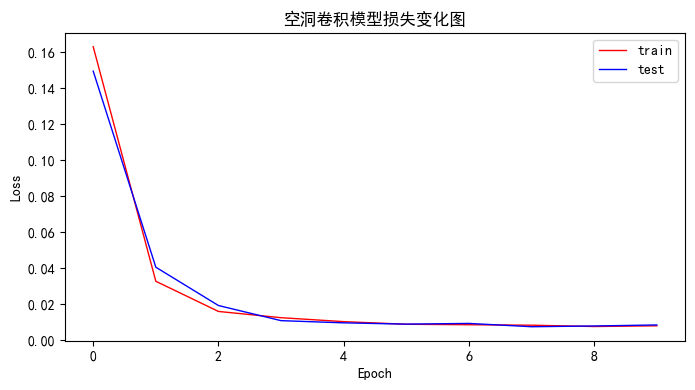

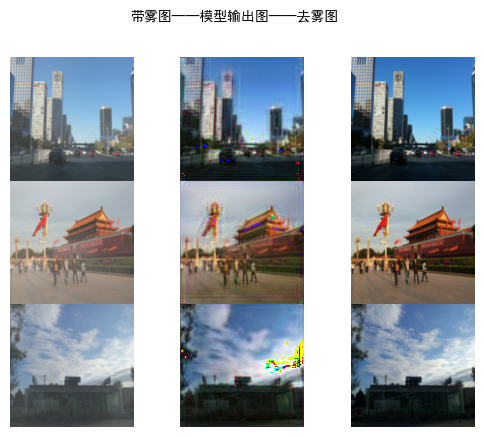

In [44]:
# 加载训练好的模型
model = DilatedConvModule()
qualitative_Analysis(model, test_dataset, 'model_dilated.pth', title="空洞卷积模型损失变化图")

## 2.空洞卷积模型与卷积模型的对比实验

### 2.1 卷积模型（没加空洞）

In [64]:
# 卷积模型

class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, 
                            kernel_size=3, stride=1, padding='same')
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out


In [20]:
# 初始化模型和超参数参数
epochs = 10
lr = 0.001

model = ConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses_conv, test_losses_conv = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_conv, 'test_losses': test_losses_conv}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_conv.pth')

Epoch: 1/10,	 train_loss: 0.1566,	 test_loss: 0.1267
Epoch: 2/10,	 train_loss: 0.0253,	 test_loss: 0.0483
Epoch: 3/10,	 train_loss: 0.0149,	 test_loss: 0.0164
Epoch: 4/10,	 train_loss: 0.0095,	 test_loss: 0.0072
Epoch: 5/10,	 train_loss: 0.0081,	 test_loss: 0.0060
Epoch: 6/10,	 train_loss: 0.0078,	 test_loss: 0.0064
Epoch: 7/10,	 train_loss: 0.0077,	 test_loss: 0.0052
Epoch: 8/10,	 train_loss: 0.0071,	 test_loss: 0.0053
Epoch: 9/10,	 train_loss: 0.0068,	 test_loss: 0.0051
Epoch: 10/10,	 train_loss: 0.0067,	 test_loss: 0.0058

训练结毕，耗时：223.5333034992218s


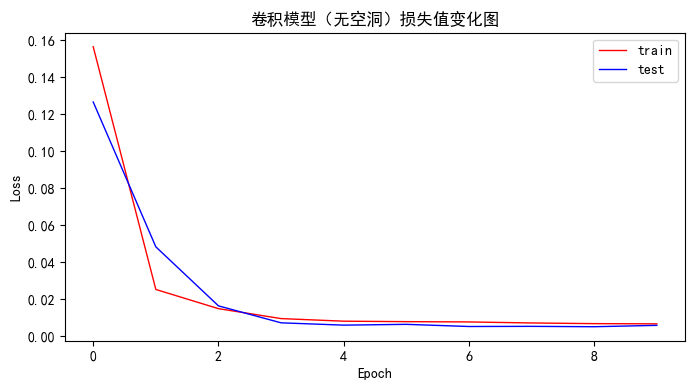

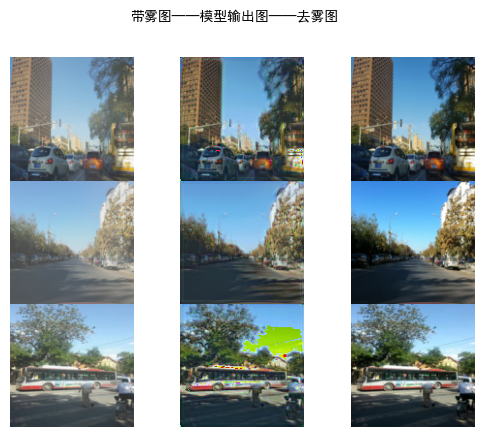

In [42]:
# 加载训练好的模型
model = ConvModule()
qualitative_Analysis(model, test_dataset, 'model_conv.pth', title="卷积模型（无空洞）损失值变化图")

### 2.2 对比实验分析
通过训练时长的柱状图可以看出，添加空洞率的卷积网络的训练时间要稍短些，训练速度更快、

从损失值上来看，大约在第2个epoch前，添加空洞率的卷积模型的训练和测试损失更小，在第2个epoch之后，没有添加孔洞率的卷积网络的损失更小，但两种模型的损失值差别不大，两者都是在第四轮之后损失值就变化不大，说明这时候模型训练的差不多了，综合来看，模型的损失值也比较小

从定性分析上来看，反而是没有加空洞率的模型去雾效果要好点，但两者的去雾效果都有不足

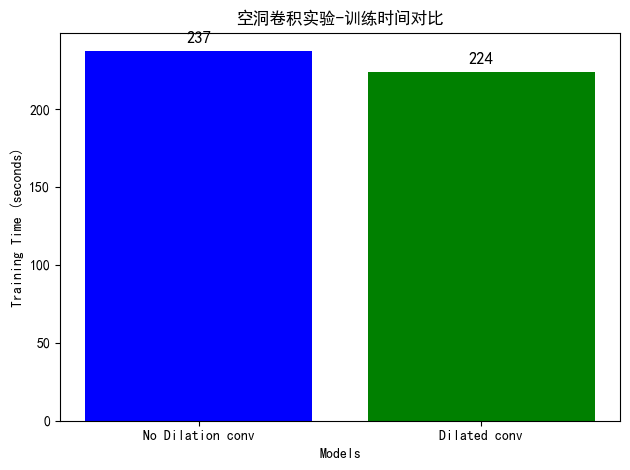

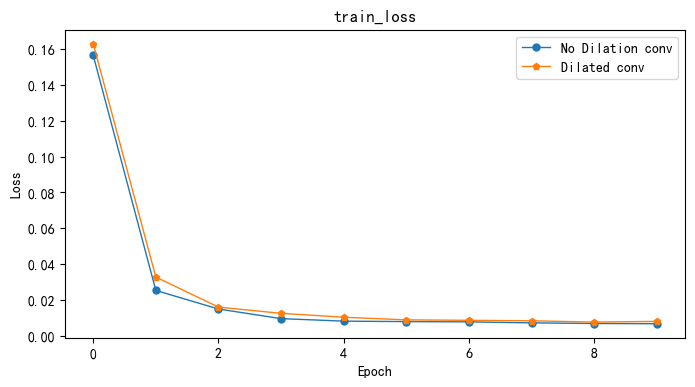

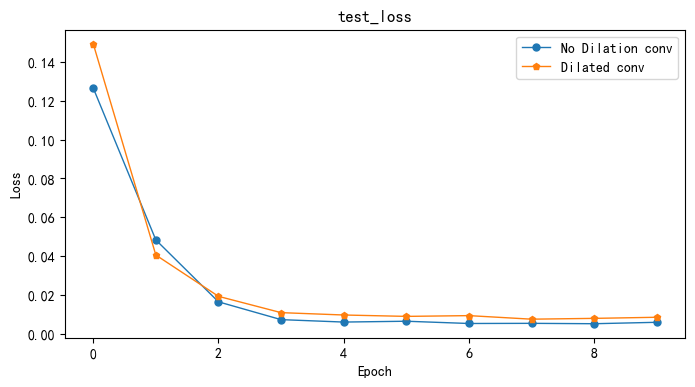

In [68]:
# 训练时间对比
model_labels = ['No Dilation conv', 'Dilated conv']
training_times = [237, 224]
train_time_comparison(training_times, model_labels, "空洞卷积实验-训练时间对比")

# 加载训练好的模型
model = ConvModule()
checkpoint = torch.load('model_conv.pth')  # 替换为你的模型检查点文件路径
# 绘制损失图
train_losses_conv, test_losses_conv = checkpoint['other_info']['train_losses'], checkpoint['other_info']['test_losses']

# 加载训练好的模型
model = DilatedConvModule()
checkpoint = torch.load('model_dilated.pth')  # 替换为你的模型检查点文件路径
# 绘制损失图
train_losses, test_losses = checkpoint['other_info']['train_losses'], checkpoint['other_info']['test_losses']

# 训练损失对比
losses_train = [train_losses_conv, train_losses]
losses_test = [test_losses_conv, test_losses]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")

## 3.不同超参数的对比实验

### 3.1 卷积层数对比实验

In [11]:
# 初始化一些通用变量
epochs = 10
lr = 0.001
criterion = nn.MSELoss()

#### 3.1.1 一层卷积

In [12]:
# 空洞卷积的实现
class DilatedConvModule_l1(nn.Module):
    def __init__(self):
        super(DilatedConvModule_l1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [13]:
model = DilatedConvModule_l1().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_l1, test_losses_l1 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_l1, 'test_losses': test_losses_l1}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_l1.pth')

Epoch: 1/10,	 train_loss: 0.0675,	 test_loss: 0.0980
Epoch: 2/10,	 train_loss: 0.0304,	 test_loss: 0.0876
Epoch: 3/10,	 train_loss: 0.0238,	 test_loss: 0.0594
Epoch: 4/10,	 train_loss: 0.0202,	 test_loss: 0.0215
Epoch: 5/10,	 train_loss: 0.0181,	 test_loss: 0.0186
Epoch: 6/10,	 train_loss: 0.0162,	 test_loss: 0.0208
Epoch: 7/10,	 train_loss: 0.0152,	 test_loss: 0.0154
Epoch: 8/10,	 train_loss: 0.0143,	 test_loss: 0.0143
Epoch: 9/10,	 train_loss: 0.0140,	 test_loss: 0.0137
Epoch: 10/10,	 train_loss: 0.0128,	 test_loss: 0.0139

训练结毕，耗时：66.75767731666565s


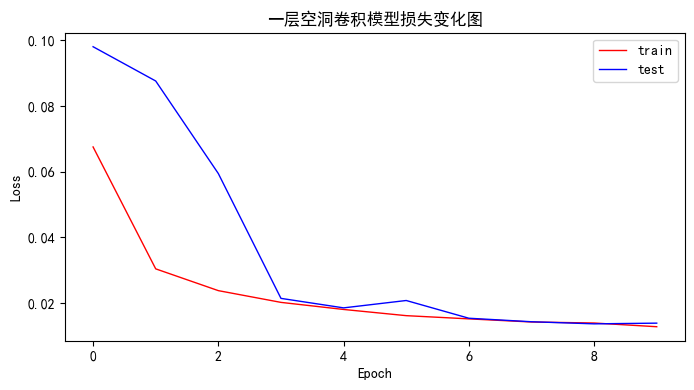

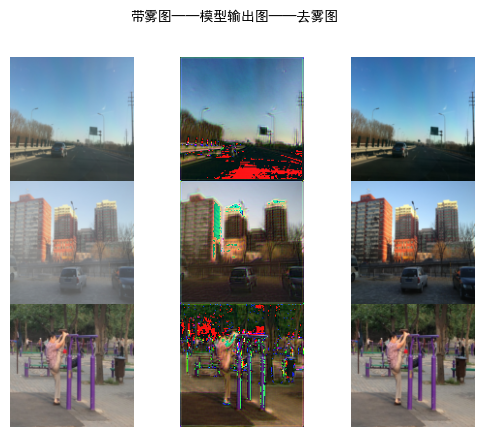

In [41]:
# 加载训练好的模型
model = DilatedConvModule_l1()
qualitative_Analysis(model, test_dataset, 'model_dilated_l1.pth', title="一层空洞卷积模型损失变化图")

#### 3.1.2 两层卷积

In [15]:
# 空洞卷积的实现
class DilatedConvModule_l2(nn.Module):
    def __init__(self):
        super(DilatedConvModule_l2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [16]:
model = DilatedConvModule_l2().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_l2, test_losses_l2 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_l2, 'test_losses': test_losses_l2}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_l2.pth')

Epoch: 1/10,	 train_loss: 0.1366,	 test_loss: 0.1024
Epoch: 2/10,	 train_loss: 0.0293,	 test_loss: 0.0341
Epoch: 3/10,	 train_loss: 0.0162,	 test_loss: 0.0156
Epoch: 4/10,	 train_loss: 0.0110,	 test_loss: 0.0119
Epoch: 5/10,	 train_loss: 0.0097,	 test_loss: 0.0087
Epoch: 6/10,	 train_loss: 0.0087,	 test_loss: 0.0086
Epoch: 7/10,	 train_loss: 0.0085,	 test_loss: 0.0083
Epoch: 8/10,	 train_loss: 0.0082,	 test_loss: 0.0084
Epoch: 9/10,	 train_loss: 0.0083,	 test_loss: 0.0074
Epoch: 10/10,	 train_loss: 0.0078,	 test_loss: 0.0076

训练结毕，耗时：111.50380039215088s


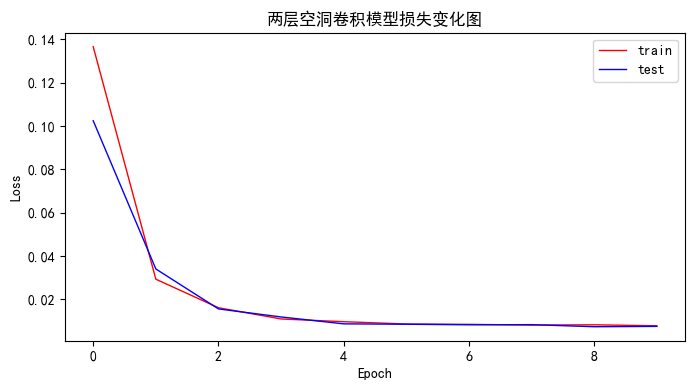

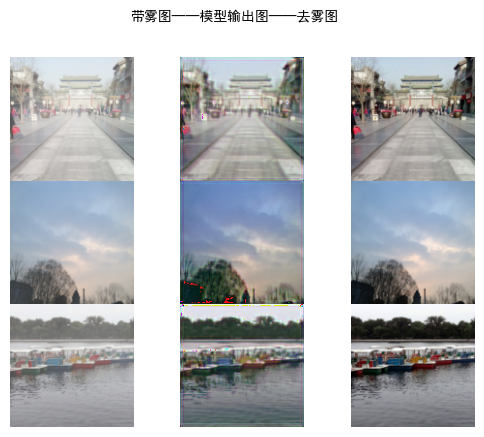

In [37]:
# 加载训练好的模型
model = DilatedConvModule_l2()
qualitative_Analysis(model, test_dataset, 'model_dilated_l2.pth', title="两层空洞卷积模型损失变化图")

#### 3.1.3 三层卷积

In [18]:
# 空洞卷积的实现
class DilatedConvModule_l3(nn.Module):
    def __init__(self):
        super(DilatedConvModule_l3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [19]:
model = DilatedConvModule_l3().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_l3, test_losses_l3 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_l3, 'test_losses': test_losses_l3}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_l3.pth')

Epoch: 1/10,	 train_loss: 0.1444,	 test_loss: 0.1455
Epoch: 2/10,	 train_loss: 0.0300,	 test_loss: 0.0489
Epoch: 3/10,	 train_loss: 0.0166,	 test_loss: 0.0204
Epoch: 4/10,	 train_loss: 0.0125,	 test_loss: 0.0122
Epoch: 5/10,	 train_loss: 0.0111,	 test_loss: 0.0100
Epoch: 6/10,	 train_loss: 0.0104,	 test_loss: 0.0094
Epoch: 7/10,	 train_loss: 0.0095,	 test_loss: 0.0091
Epoch: 8/10,	 train_loss: 0.0088,	 test_loss: 0.0079
Epoch: 9/10,	 train_loss: 0.0085,	 test_loss: 0.0077
Epoch: 10/10,	 train_loss: 0.0084,	 test_loss: 0.0081

训练结毕，耗时：238.0504548549652s


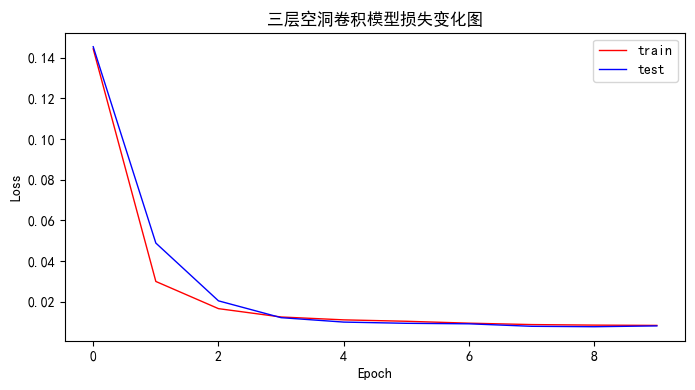

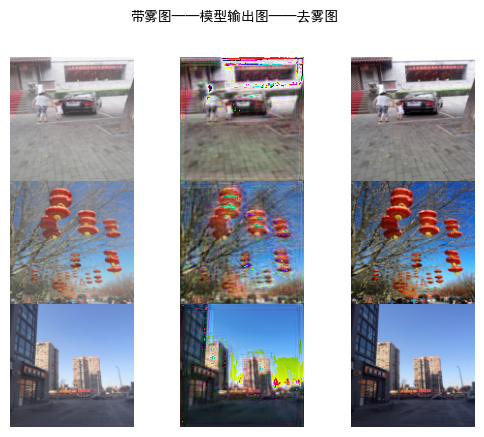

In [45]:
# 加载训练好的模型
model = DilatedConvModule_l3()
qualitative_Analysis(model, test_dataset, 'model_dilated_l3.pth', title="三层空洞卷积模型损失变化图")

#### 3.1.4 实验结果分析

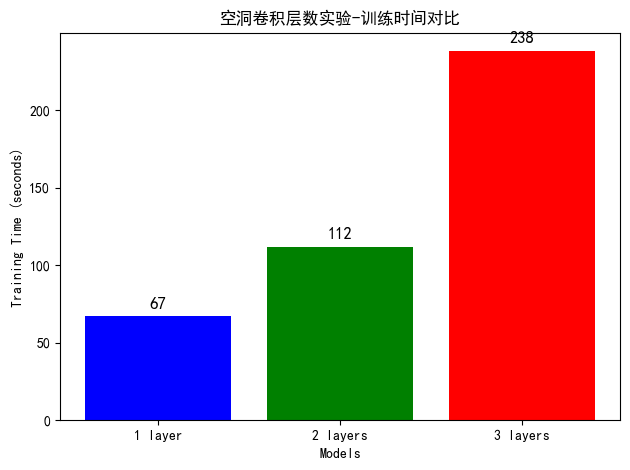

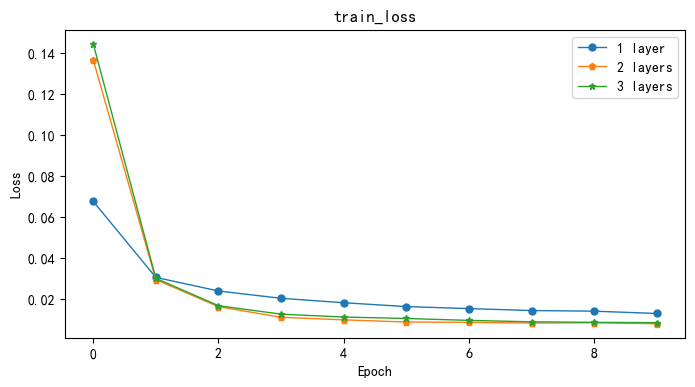

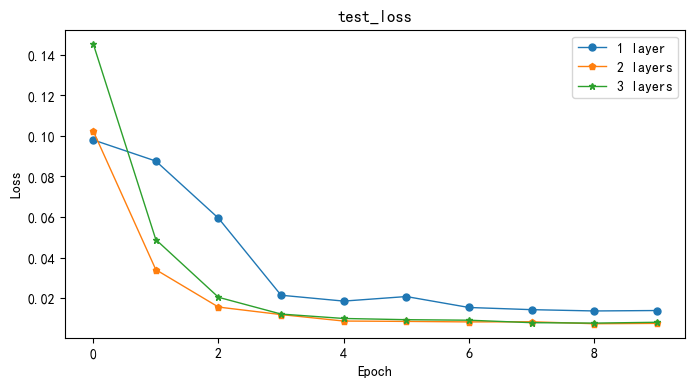

In [59]:
# 训练时间对比
model_labels = ['1 layer', '2 layers', '3 layers']
training_times = [67, 112, 238]
train_time_comparison(training_times, model_labels, "空洞卷积层数实验-训练时间对比")

# 训练损失对比
losses_train = [train_losses_l1, train_losses_l2, train_losses_l3]
losses_test = [test_losses_l1, test_losses_l2, test_losses_l3]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")

### 3.2 dilation对比实验

In [21]:
# 初始化通用变量
epochs = 10
lr = 0.001
criterion = nn.MSELoss()

#### 3.2.1 dilation=1

In [22]:
# 空洞卷积的实现
class DilatedConvModule_d1(nn.Module):
    def __init__(self):
        super(DilatedConvModule_d1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(64),
        )
        self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [23]:
model = DilatedConvModule_d1().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_d1, test_losses_d1 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_d1, 'test_losses': test_losses_d1}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_d1.pth')

Epoch: 1/10,	 train_loss: 0.2561,	 test_loss: 0.1842
Epoch: 2/10,	 train_loss: 0.1514,	 test_loss: 0.1608
Epoch: 3/10,	 train_loss: 0.1065,	 test_loss: 0.0949
Epoch: 4/10,	 train_loss: 0.0609,	 test_loss: 0.0423
Epoch: 5/10,	 train_loss: 0.0261,	 test_loss: 0.0271
Epoch: 6/10,	 train_loss: 0.0137,	 test_loss: 0.0172
Epoch: 7/10,	 train_loss: 0.0093,	 test_loss: 0.0086
Epoch: 8/10,	 train_loss: 0.0079,	 test_loss: 0.0127
Epoch: 9/10,	 train_loss: 0.0086,	 test_loss: 0.0090
Epoch: 10/10,	 train_loss: 0.0074,	 test_loss: 0.0085

训练结毕，耗时：105.80064511299133s


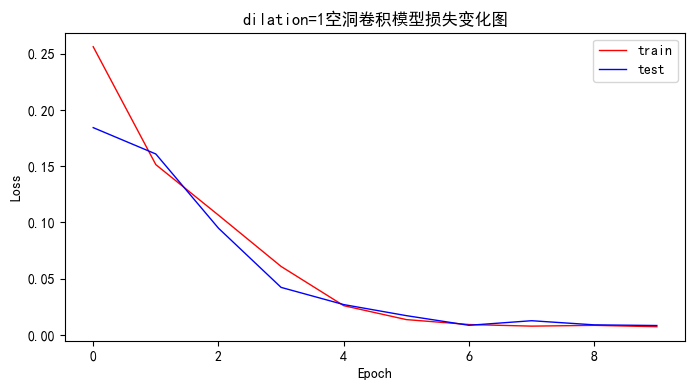

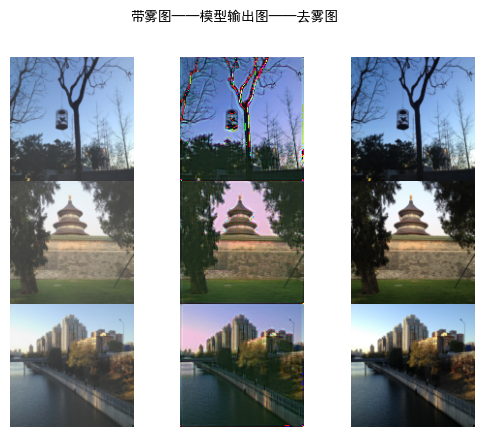

In [31]:
# 加载训练好的模型
model = DilatedConvModule_d1()
qualitative_Analysis(model, test_dataset, 'model_dilated_d1.pth', title="dilation=1空洞卷积模型损失变化图")

#### 3.2.2 dilation=2

In [25]:
# 空洞卷积的实现
class DilatedConvModule_d2(nn.Module):
    def __init__(self):
        super(DilatedConvModule_d2, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=2),
            nn.BatchNorm2d(64),
        )
        self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [26]:
model = DilatedConvModule_d2().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_d2, test_losses_d2 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_d2, 'test_losses': test_losses_d2}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_d2.pth')

Epoch: 1/10,	 train_loss: 0.2920,	 test_loss: 0.1851
Epoch: 2/10,	 train_loss: 0.1652,	 test_loss: 0.1623
Epoch: 3/10,	 train_loss: 0.1131,	 test_loss: 0.1466
Epoch: 4/10,	 train_loss: 0.0653,	 test_loss: 0.0936
Epoch: 5/10,	 train_loss: 0.0292,	 test_loss: 0.0325
Epoch: 6/10,	 train_loss: 0.0143,	 test_loss: 0.0154
Epoch: 7/10,	 train_loss: 0.0123,	 test_loss: 0.0135
Epoch: 8/10,	 train_loss: 0.0102,	 test_loss: 0.0088
Epoch: 9/10,	 train_loss: 0.0095,	 test_loss: 0.0174
Epoch: 10/10,	 train_loss: 0.0097,	 test_loss: 0.0114

训练结毕，耗时：108.31408762931824s


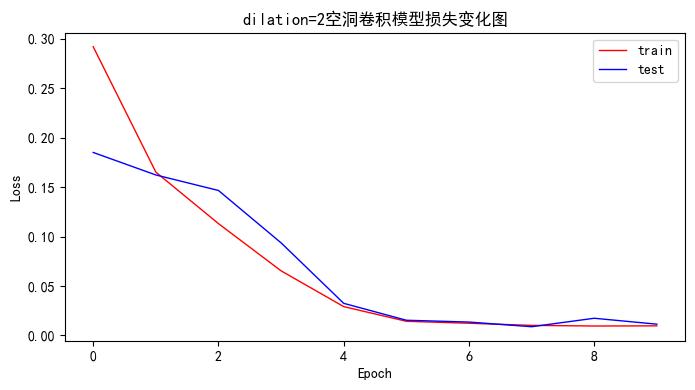

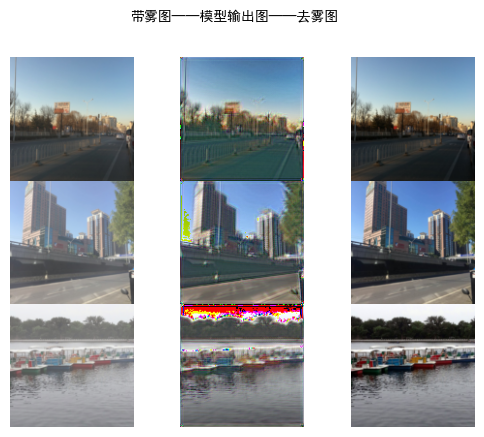

In [27]:
# 加载训练好的模型
model = DilatedConvModule_d2()
qualitative_Analysis(model, test_dataset, 'model_dilated_d2.pth', title="dilation=2空洞卷积模型损失变化图")

#### 3.2.3 dilation=3

In [28]:
# 空洞卷积的实现
class DilatedConvModule_d3(nn.Module):
    def __init__(self):
        super(DilatedConvModule_d3, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=3),
            nn.BatchNorm2d(64),
        )
        self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [29]:
model = DilatedConvModule_d3().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses_d3, test_losses_d3 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_d3, 'test_losses': test_losses_d3}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_d3.pth')

Epoch: 1/10,	 train_loss: 0.3292,	 test_loss: 0.2482
Epoch: 2/10,	 train_loss: 0.1836,	 test_loss: 0.2219
Epoch: 3/10,	 train_loss: 0.1260,	 test_loss: 0.1636
Epoch: 4/10,	 train_loss: 0.0681,	 test_loss: 0.0759
Epoch: 5/10,	 train_loss: 0.0289,	 test_loss: 0.0255
Epoch: 6/10,	 train_loss: 0.0163,	 test_loss: 0.0216
Epoch: 7/10,	 train_loss: 0.0138,	 test_loss: 0.0294
Epoch: 8/10,	 train_loss: 0.0132,	 test_loss: 0.0174
Epoch: 9/10,	 train_loss: 0.0105,	 test_loss: 0.0109
Epoch: 10/10,	 train_loss: 0.0090,	 test_loss: 0.0111

训练结毕，耗时：109.12000775337219s


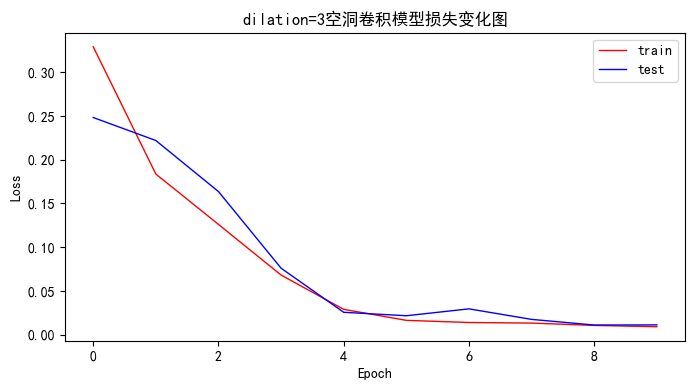

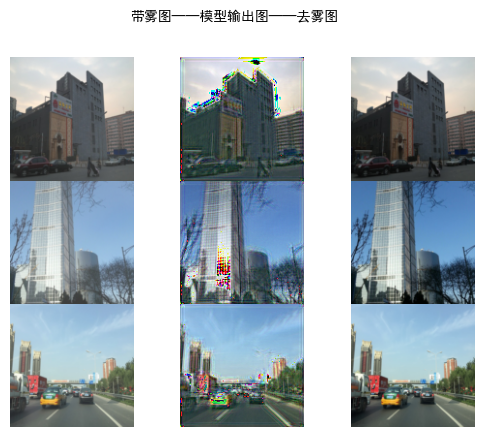

In [48]:
# 加载训练好的模型
model = DilatedConvModule_d3()
qualitative_Analysis(model, test_dataset, 'model_dilated_d3.pth', title="dilation=3空洞卷积模型损失变化图")

#### 3.2.4 实验结果分析
三种空洞率对应的训练时长差别不大

就模型效果而言，dilation=3的定性分析结果较好，本轮对比实验选取的模型层数为两层，其中第一层卷积的dilation均为1，第二层卷积层的dilation分别设为1,2,3，这样是为了一定程度上符合HDC原则

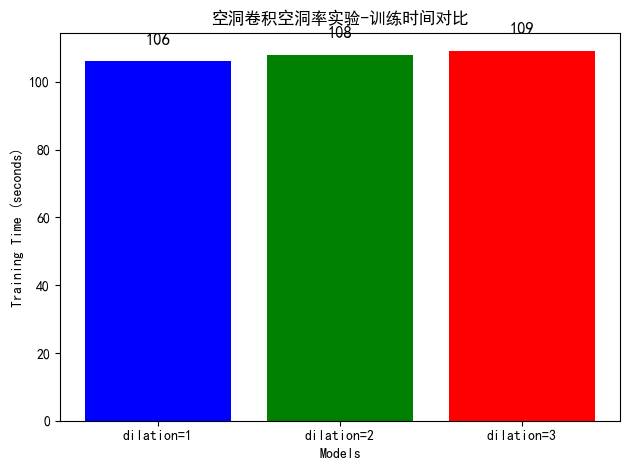

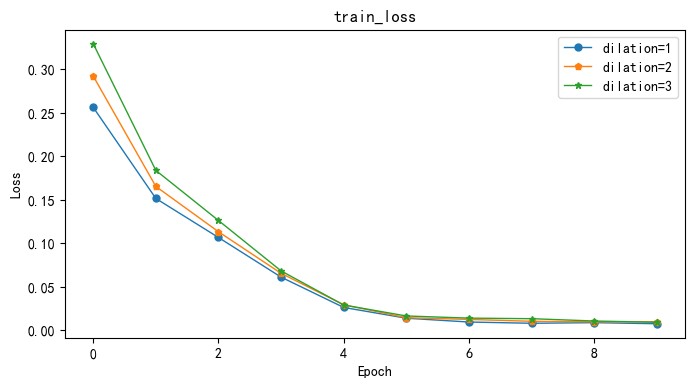

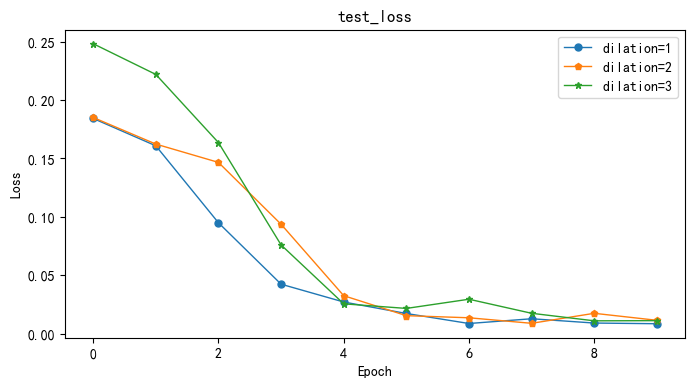

In [60]:
# 训练时间对比
model_labels = ['dilation=1', 'dilation=2', 'dilation=3']
training_times = [106, 108, 109]
train_time_comparison(training_times, model_labels, "空洞卷积空洞率实验-训练时间对比")

# 训练损失对比
losses_train = [train_losses_d1, train_losses_d2, train_losses_d3]
losses_test = [test_losses_d1, test_losses_d2, test_losses_d3]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")

### 3.3 学习率对比实验

In [49]:
# 定义卷积模型
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, 
                      padding='same', dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

In [50]:
# 初始化模型和超参数参数
epochs = 10
criterion = nn.MSELoss()

#### 3.3.1 learning_rate=0.1

In [51]:
lr = 0.1
model = DilatedConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses_lr1, test_losses_lr1 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_lr1, 'test_losses': test_losses_lr1}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_lr1.pth')

Epoch: 1/10,	 train_loss: 221.9688,	 test_loss: 24.5523
Epoch: 2/10,	 train_loss: 0.3064,	 test_loss: 0.3079
Epoch: 3/10,	 train_loss: 0.1453,	 test_loss: 0.3077
Epoch: 4/10,	 train_loss: 0.1274,	 test_loss: 0.1039
Epoch: 5/10,	 train_loss: 0.0911,	 test_loss: 0.0800
Epoch: 6/10,	 train_loss: 0.0817,	 test_loss: 0.0766
Epoch: 7/10,	 train_loss: 0.0781,	 test_loss: 0.0755
Epoch: 8/10,	 train_loss: 0.0771,	 test_loss: 0.0747
Epoch: 9/10,	 train_loss: 0.0767,	 test_loss: 0.0743
Epoch: 10/10,	 train_loss: 0.0763,	 test_loss: 0.0741

训练结毕，耗时：237.09397768974304s


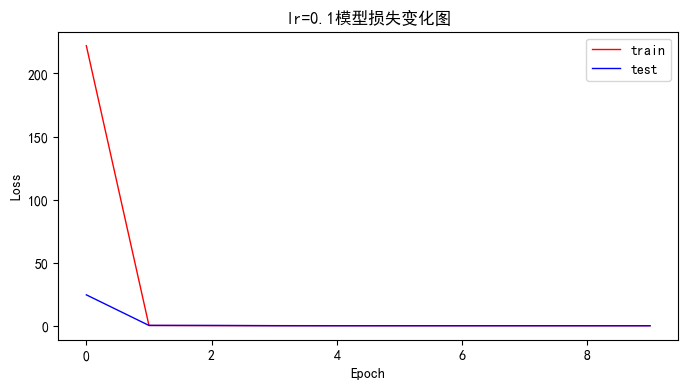

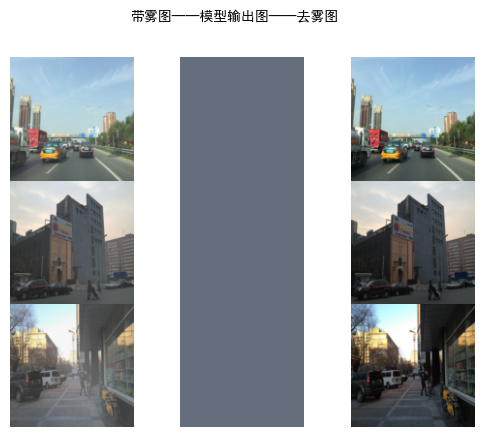

In [52]:
# 加载训练好的模型
model = DilatedConvModule()
qualitative_Analysis(model, test_dataset, 'model_dilated_lr1.pth', title="lr=0.1模型损失变化图")

#### 3.3.2 learning_rate=0.01

In [53]:
lr = 0.01
model = DilatedConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses_lr2, test_losses_lr2 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_lr2, 'test_losses': test_losses_lr2}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_lr2.pth')

Epoch: 1/10,	 train_loss: 4.7120,	 test_loss: 0.2422
Epoch: 2/10,	 train_loss: 0.4556,	 test_loss: 0.6549
Epoch: 3/10,	 train_loss: 0.1375,	 test_loss: 0.0915
Epoch: 4/10,	 train_loss: 0.0618,	 test_loss: 0.0384
Epoch: 5/10,	 train_loss: 0.0318,	 test_loss: 0.0264
Epoch: 6/10,	 train_loss: 0.0274,	 test_loss: 0.0230
Epoch: 7/10,	 train_loss: 0.0246,	 test_loss: 0.0224
Epoch: 8/10,	 train_loss: 0.0219,	 test_loss: 0.0192
Epoch: 9/10,	 train_loss: 0.0211,	 test_loss: 0.0177
Epoch: 10/10,	 train_loss: 0.0194,	 test_loss: 0.0171

训练结毕，耗时：266.9560458660126s


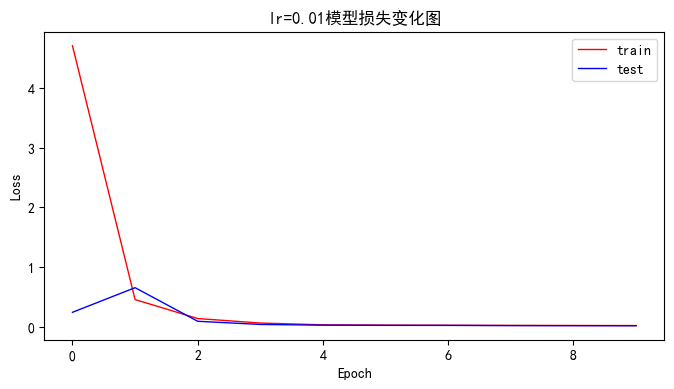

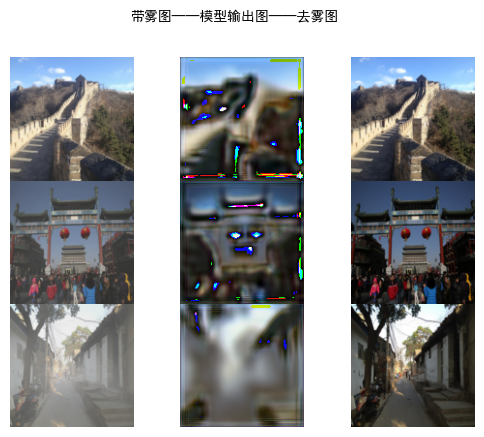

In [54]:
# 加载训练好的模型
model = DilatedConvModule()
qualitative_Analysis(model, test_dataset, 'model_dilated_lr2.pth', title="lr=0.01模型损失变化图")

#### 3.3.3 learning_rate=0.001

In [55]:
lr = 0.001
model = DilatedConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


train_losses_lr3, test_losses_lr3 = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_lr3, 'test_losses': test_losses_lr3}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_dilated_lr3.pth')

Epoch: 1/10,	 train_loss: 0.1256,	 test_loss: 0.1518
Epoch: 2/10,	 train_loss: 0.0245,	 test_loss: 0.0672
Epoch: 3/10,	 train_loss: 0.0141,	 test_loss: 0.0221
Epoch: 4/10,	 train_loss: 0.0111,	 test_loss: 0.0113
Epoch: 5/10,	 train_loss: 0.0100,	 test_loss: 0.0088
Epoch: 6/10,	 train_loss: 0.0091,	 test_loss: 0.0083
Epoch: 7/10,	 train_loss: 0.0081,	 test_loss: 0.0081
Epoch: 8/10,	 train_loss: 0.0088,	 test_loss: 0.0089
Epoch: 9/10,	 train_loss: 0.0081,	 test_loss: 0.0079
Epoch: 10/10,	 train_loss: 0.0079,	 test_loss: 0.0080

训练结毕，耗时：291.8916518688202s


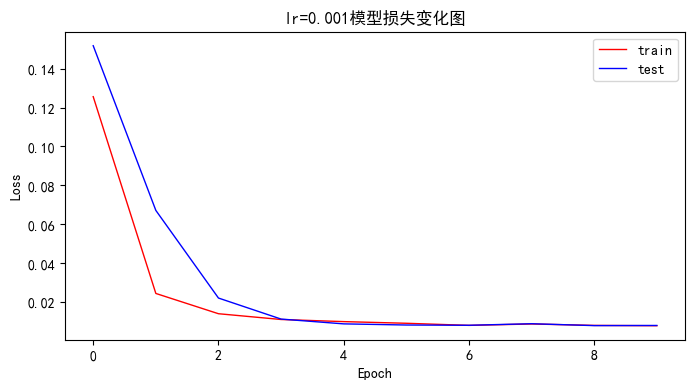

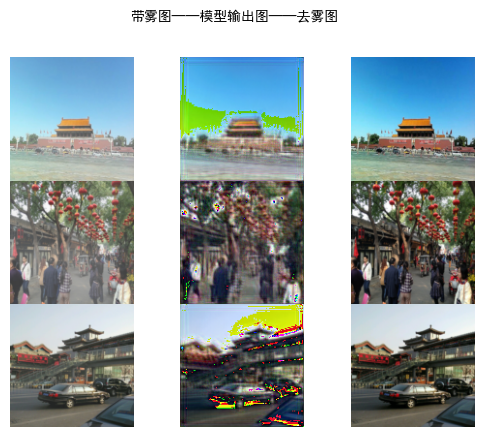

In [56]:
# 加载训练好的模型
model = DilatedConvModule()
qualitative_Analysis(model, test_dataset, 'model_dilated_lr3.pth', title="lr=0.001模型损失变化图")

#### 3.3.4 实验结果分析
从上面三个定性分析的图片就可以看出，用卷积神经网络对图像进行去雾实验时，学习率不能选大的学习率，0.1和0.01的效果都很差，其中学习率为0.1时模型生成的图片是灰图，分析原因可能是因为学习率过大，导致模型参数更新时找不到局部最优点，进而导致卷积核没能训练完全。卷积操作之后的生成结果就是绘图

learning_rate=0.001的去雾效果还算凑合，但也有一些区域失真，分析原因是因为模型的参数量还不够大，训练的卷积核还不够完全，在进行卷积操作时难免有些区域会失真

从训练时间上看，合乎常理，学习率越小训练时长越大

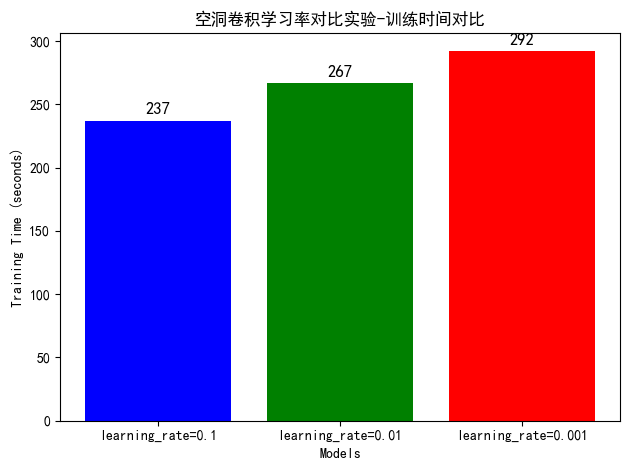

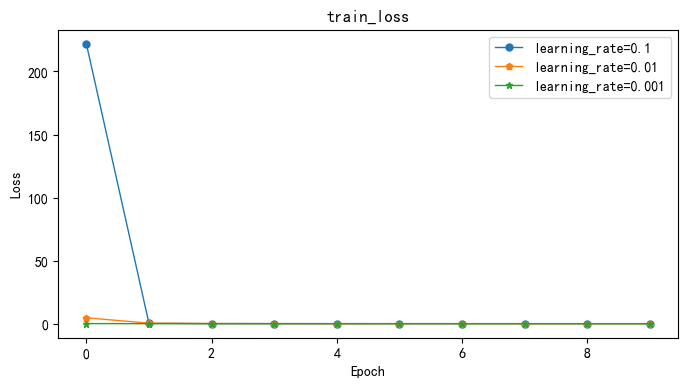

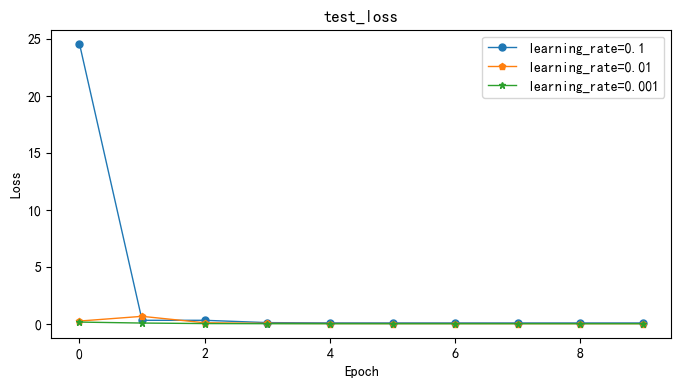

In [61]:
# 训练时间对比
model_labels = ['learning_rate=0.1', 'learning_rate=0.01', 'learning_rate=0.001']
training_times = [237, 267, 292]
train_time_comparison(training_times, model_labels, "空洞卷积学习率对比实验-训练时间对比")

# 训练损失对比
losses_train = [train_losses_lr1, train_losses_lr2, train_losses_lr3]
losses_test = [test_losses_lr1, test_losses_lr2, test_losses_lr3]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")